In [28]:
import time
import subprocess
import matplotlib.pyplot as plt
import psutil
import os
import re
import threading
import csv
import signal
import numpy as np
import math


In [2]:
programs = ["./build/fuzzer","./build/vmfuzzer"]

In [3]:
directory = './grammars'
files = os.listdir(directory)
print(files)


['math.json', 'recursive.json', 'simple_grammar.json', 'css.json', 'html.json']


In [4]:
depth = [1,2,4,8,16,32,64,128,256,512,1024,2048]

In [5]:
#process = subprocess.Popen([programs[0],"-depth","2048", "-path", "./grammars/html.json", "-o", "html.c"],stderr=subprocess.PIPE,stdout=subprocess.PIPE)

In [7]:
throughput_rates = []

def monitor_process(process, timeout):
    time.sleep(timeout)
    if process.poll() is None:  
        process.terminate()
        try:
            process.wait(timeout=5)
        except subprocess.TimeoutExpired:
            process.kill()
            print("Process was killed after timeout")

def read_output(process):
    global throughput_rates
    while True:
        output = process.stdout.readline()
        if process.poll() is not None and output == '':
            break
        if output:
            match = re.search(r'Throughput Rate:\s*([\d.]+)\s*MB/s', output)
            if match:
                throughput_rate = float(match.group(1))
                throughput_rates.append(throughput_rate)


result = {}
timeout = 120

for i in range(len(programs)):
    program_name = programs[i]
    result[program_name] = {}
    for j in range(len(files)):
        file_name = files[j]
        result[program_name][file_name] = {}
        for k in range(len(depth)):
            depth_value = depth[k]
            throughput_rates = []
            process = subprocess.Popen(
                [program_name, "-depth", str(depth[k]), "-path", f"./grammars/{files[j]}", "-o", f"{file_name}.c"],
            )
            process.wait()   
            generated_program = f"{file_name}.c.out"
            process = subprocess.Popen(
                ['./'+generated_program],
                stderr=subprocess.PIPE,
                stdout=subprocess.PIPE,
                text=True,
            )
            monitor_thread = threading.Thread(target=monitor_process, args=(process, timeout))
            monitor_thread.daemon = True  
            monitor_thread.start()
            read_output(process)
            monitor_thread.join()
            if process.poll() is None:
                process.terminate()
                try:
                    process.wait(timeout=5)
                except subprocess.TimeoutExpired:
                    process.kill()
            if throughput_rates:
                avg_throughput_rate = sum(throughput_rates) / len(throughput_rates)
            else:
                avg_throughput_rate = 0
            result[program_name][file_name][depth_value] = avg_throughput_rate
            print(f"{program_name} {file_name} {depth_value} {avg_throughput_rate}")
print(result)


Code written to file successfully.
./build/fuzzer math.json 1 304.05281042976
Code written to file successfully.
./build/fuzzer math.json 2 210.95029638714425
Code written to file successfully.
./build/fuzzer math.json 4 212.2241700758297
Code written to file successfully.
./build/fuzzer math.json 8 159.8655736128871
Code written to file successfully.
./build/fuzzer math.json 16 138.59975546357634
Code written to file successfully.
./build/fuzzer math.json 32 0
Code written to file successfully.
./build/fuzzer math.json 64 0
Code written to file successfully.
./build/fuzzer math.json 128 0
Code written to file successfully.
./build/fuzzer math.json 256 0
Code written to file successfully.
./build/fuzzer math.json 512 0
Code written to file successfully.
./build/fuzzer math.json 1024 0
Code written to file successfully.
./build/fuzzer math.json 2048 0
Code written to file successfully.
./build/fuzzer recursive.json 1 365.9452858876607
Code written to file successfully.
./build/fuzzer re

In [8]:
with open('results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Program', 'File', 'Depth', 'Average Throughput Rate (MB/s)'])
    for program_name, files_dict in result.items():
        for file_name, depths_dict in files_dict.items():
            for depth_value, avg_throughput_rate in depths_dict.items():
                writer.writerow([program_name, file_name, depth_value, avg_throughput_rate])

print("Results have been written to results.csv")

Results have been written to results.csv


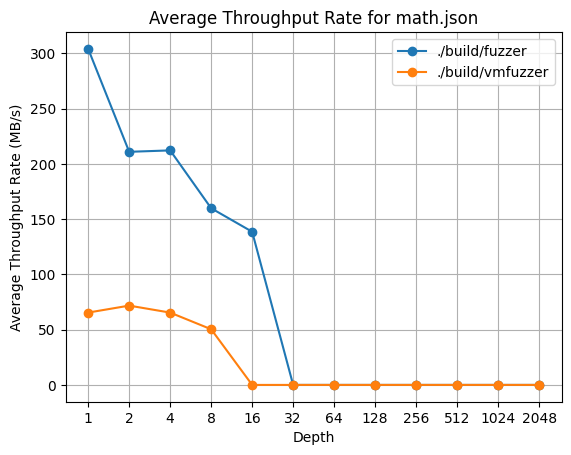

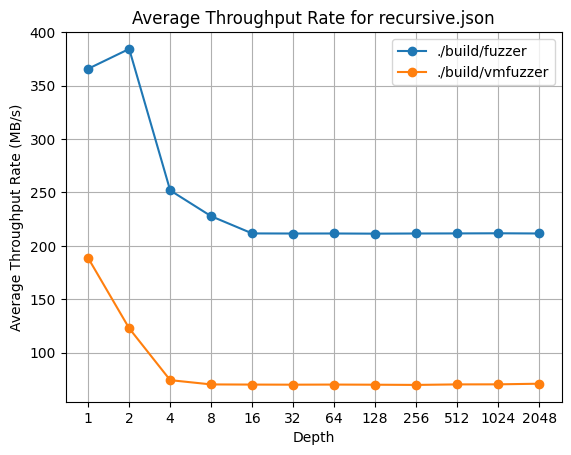

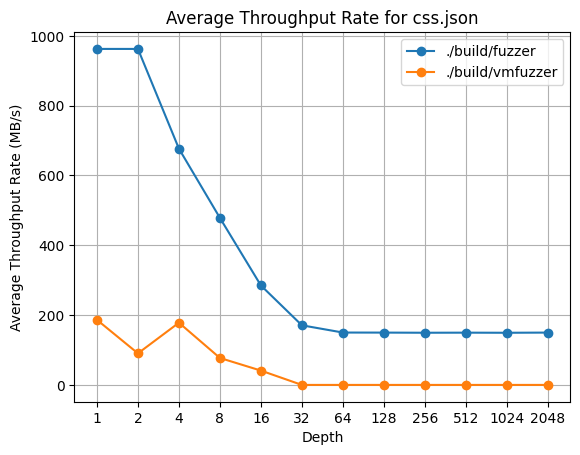

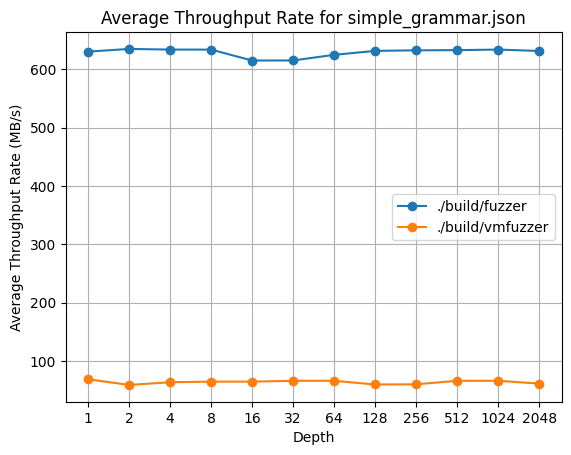

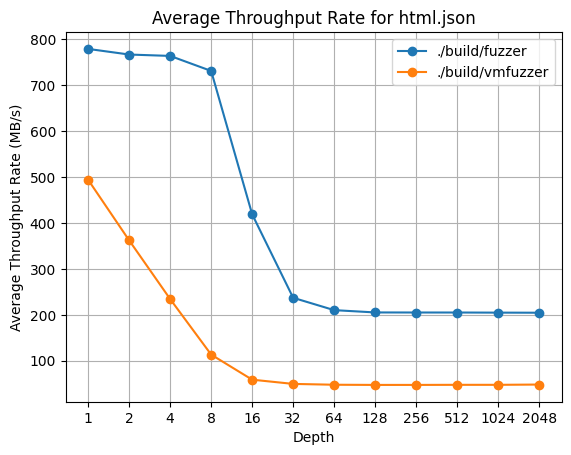

In [36]:
# 定义CSV文件名
csv_filename = 'results.csv'

# 读取CSV文件中的数据
results = {}

with open(csv_filename, mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        program_name = row['Program']
        file_name = row['File']
        depth = int(row['Depth'])
        avg_throughput_rate = float(row['Average Throughput Rate (MB/s)'])

        if program_name not in results:
            results[program_name] = {}
        if file_name not in results[program_name]:
            results[program_name][file_name] = {}

        if depth not in results[program_name][file_name]:
            results[program_name][file_name][depth] = []
        
        results[program_name][file_name][depth].append(avg_throughput_rate)

for file_name in {file_name for program_data in results.values() for file_name in program_data.keys()}:
    plt.figure()
    for program_name in results.keys():
        if file_name in results[program_name]:
            depths = sorted(results[program_name][file_name].keys())
            rates = [results[program_name][file_name][d] for d in depths]
            plt.plot([math.log(x,2) for x in depths], rates, marker='o', label=program_name)
    
    plt.xlabel('Depth')
    plt.ylabel('Average Throughput Rate (MB/s)')
    plt.title(f'Average Throughput Rate for {file_name}')
    plt.legend()
    plt.grid(True)

    plt.xticks([math.log(x,2) for x in depths], [str(d) for d in depths])

    plt.savefig(f"{file_name}_throughput.png")
    plt.show()